# Simulating the elastic Marmousi model

_Copyright Lars Gebraad, 2022_ https://github.com/larsgeb/psvWave

In this notebook it is shown how the `psvWave` package is used to simulate the elastic wavefields through a typical model of a geological structure, by using the AGL Elastic Marmousi model. Note that this notebook (and psvWave in general) uses moment tensor sources, instead of volume/force injections.


> Martin, G. S., Wiley, R., and Marfurt, K. J., 2006, Marmousi2: An elastic
upgrade for Marmousi: The Leading Edge, 25, 156–166.
doi:10.1190/1.2172306

In [1]:
import psvWave
import numpy
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


font = { "size": 26}
matplotlib.rc("font", **font)


def interpolate_missing_pixels(image, method="nearest", fill_value=0):
    # https://stackoverflow.com/a/68558547/6848887, https://creativecommons.org/licenses/by-sa/4.0/
    
    mask = numpy.ma.masked_invalid(image).mask
    
    h, w = image.shape[:2]
    xx, yy = numpy.meshgrid(numpy.arange(w), numpy.arange(h))
    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]
    interp_values = interpolate.griddata(
        (known_x, known_y),
        known_v,
        (missing_x, missing_y),
        method=method,
        fill_value=fill_value,
    )
    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values
    return interp_image

First, we load the marmousi model (which was already subsampled x4), and subsample it some further. We don't want to make our simulations too expensive! We will additionally remove the water layer, and use only a cut out.

Note that the original Marmousi model has a grid spacing of 1.25 meters. With the combined x4 x2 subsampling, that leaves a grid spacing of 10 meters.

In [2]:
class medium:
    pass


marmousi = medium()

density_file = "../marmousi/density-16-sub4.npy"
s_veloc_file = "../marmousi/swave-16-sub4.npy"
p_veloc_file = "../marmousi/pwave-16-sub4.npy"

marmousi.density = numpy.load(density_file).astype(numpy.float32) * 1000
marmousi.s_veloc = numpy.load(s_veloc_file).astype(numpy.float32)
marmousi.p_veloc = numpy.load(p_veloc_file).astype(numpy.float32)

water_start = numpy.argmin(marmousi.s_veloc[0, :] == 0)

subsampling = 2

marmousi.density = marmousi.density[1000:2500:subsampling, water_start::subsampling]
marmousi.s_veloc = marmousi.s_veloc[1000:2500:subsampling, water_start::subsampling]
marmousi.p_veloc = marmousi.p_veloc[1000:2500:subsampling, water_start::subsampling]

nx, nz = marmousi.density.shape
dx,dz=10,10

Let's visualize the model we just loaded.

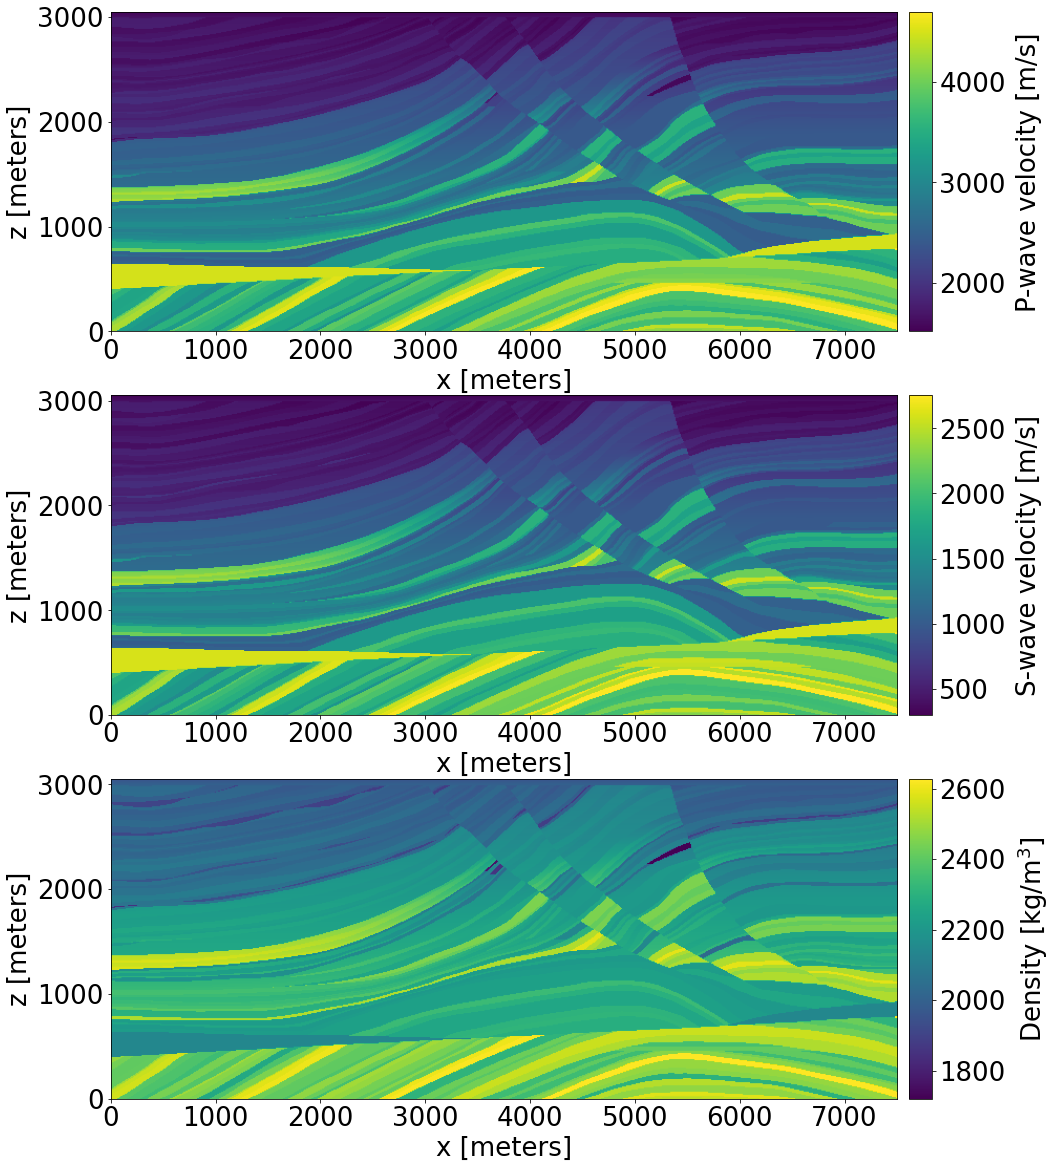

In [4]:
fig = plt.figure(figsize=(16, 20))

plt.tight_layout()

plt.subplot(311)
im = plt.imshow(marmousi.p_veloc.T, extent=[0,nx*dx,0,nz*dz])
plt.xlabel("x [meters]")
plt.ylabel("z [meters]")
ax1_divider = make_axes_locatable(plt.gca())
cax1 = ax1_divider.append_axes("right", size="3%", pad="1.5%")
cb1 = fig.colorbar(im, cax=cax1)
cax1.set_ylabel("P-wave velocity [m/s]", labelpad=10)

plt.subplot(312)
im = plt.imshow(marmousi.s_veloc.T, extent=[0,nx*dx,0,nz*dz])
plt.xlabel("x [meters]")
plt.ylabel("z [meters]")
ax1_divider = make_axes_locatable(plt.gca())
cax1 = ax1_divider.append_axes("right", size="3%", pad="1.5%")
cb1 = fig.colorbar(im, cax=cax1)
cax1.set_ylabel("S-wave velocity [m/s]", labelpad=10)

plt.subplot(313)
im = plt.imshow(marmousi.density.T, extent=[0,nx*dx,0,nz*dz])
plt.xlabel("x [meters]")
plt.ylabel("z [meters]")
ax1_divider = make_axes_locatable(plt.gca())
cax1 = ax1_divider.append_axes("right", size="3%", pad="1.5%")
cb1 = fig.colorbar(im, cax=cax1)
_ = cax1.set_ylabel("Density [kg/m$^3$]", labelpad=10)

Next, we'll set up the simulations that we want to run. The domain part is mostly defined by the medium. Feel free to tweak the rest of the settings.

In [4]:
settings = psvWave.get_dictionary()


settings = {
    "domain": {
        "nt": 12000,
        "nx_inner": nx,
        "nz_inner": nz,
        "nx_inner_boundary": 0,
        "nz_inner_boundary": 0,
        "dx": 5.0 * subsampling,  # 5 refers to the original subsampling grid size
        "dz": 5.0 * subsampling,
        "dt": 0.0005 * subsampling,
    },
    "boundary": {"np_boundary": 50, "np_factor": 0.5e-2},
    "medium": {"scalar_rho": 1500.0, "scalar_vp": 2000.0, "scalar_vs": 800.0},
    "sources": {
        "peak_frequency": 10.0 / subsampling,
        "n_sources": 1,
        "n_shots": 1,
        "source_timeshift": 0.005,
        "delay_cycles_per_shot": 24,
        "moment_angles": [90],
        "ix_sources": [10],
        "iz_sources": [240],
        "which_source_to_fire_in_which_shot": [[0]],
    },
    "receivers": {
        "nr": 26,
        "ix_receivers": list(numpy.linspace(50, 250, 26, dtype=int)),
        "iz_receivers": [10] * 26,
    },
    "inversion": {"snapshot_interval": 10 * 2},
    "basis": {"npx": 1, "npz": 1},
    "output": {"observed_data_folder": ".", "stf_folder": "."},
}

Let's check if we satisfy the CFL criterion.

In [5]:
cfl = 2 * (settings["domain"]["dt"] * marmousi.p_veloc.max()) / settings["domain"]["dx"]

cfl

0.9400000000000001

Perfect, just below 1!

Let's store our config so the solver can load it.

In [6]:
psvWave.write_dictionary("marmousi.conf", settings)

solver = psvWave.fdModel("marmousi.conf")

Loading configuration file: 'marmousi.conf'.
Parsing passed configuration.


The solver we just initialized has started with the medium parameters as defined in the settings, i.e. there are homogeneous media loaded as the current medium. Let's replace those the Marmousi model. Unfortunately, we still have to extent the Marmousi model such that it covers the absorbing boundary (`np_boundary` number of extra points on all sides). To do this, we use Nearest Neighbor extrapolation.

In [7]:
p, s, d = solver.get_parameter_fields()


np = settings["boundary"]["np_boundary"]

p[:] = numpy.nan
s[:] = numpy.nan
d[:] = numpy.nan

p[np:-np, np:-np] = marmousi.p_veloc
s[np:-np, np:-np] = marmousi.s_veloc
d[np:-np, np:-np] = marmousi.density

p = interpolate_missing_pixels(p)
s = interpolate_missing_pixels(s)
d = interpolate_missing_pixels(d)

Let's have a look at how this wonky model looks. 

Text(0, 0.5, 'P-wave velocity [m/s]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


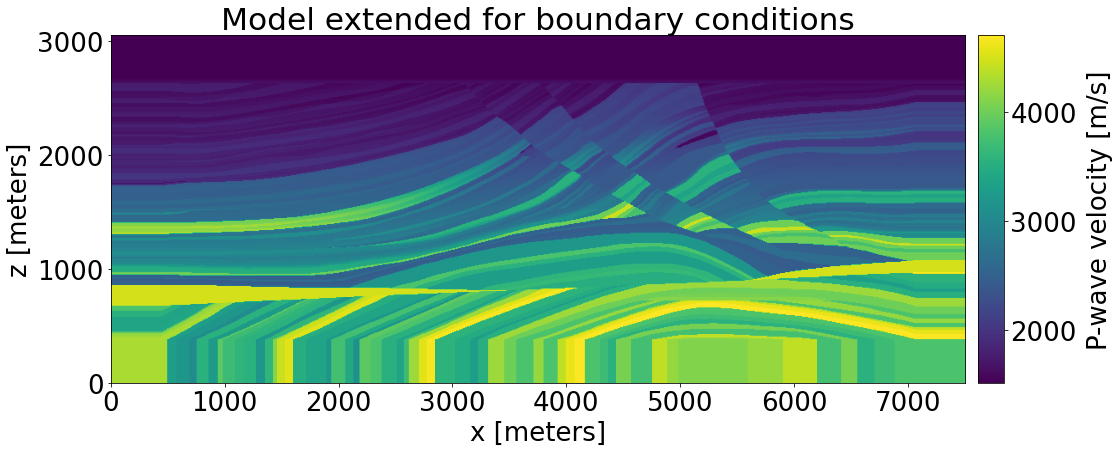

In [8]:
fig = plt.figure(figsize=(16, 7))

plt.title("Model extended for boundary conditions")
im = plt.imshow(p.T, extent=[0,nx*dx,0,nz*dz])
plt.xlabel("x [meters]")
plt.ylabel("z [meters]")
ax1_divider = make_axes_locatable(plt.gca())
cax1 = ax1_divider.append_axes("right", size="3%", pad="1.5%")
cb1 = fig.colorbar(im, cax=cax1)
cax1.set_ylabel("P-wave velocity [m/s]", labelpad=10)

Looks sensible. Let's load this into the solver and perform the simulation on 6 cores.

In [9]:
solver.set_parameter_fields(p, s, d)

In [10]:
%%time
for i_shot in range(solver.n_shots):
    solver.forward_simulate(i_shot, omp_threads_override=6)

CPU times: user 55.6 s, sys: 3.12 s, total: 58.7 s
Wall time: 9.86 s


Let's have a look at the displacements recoreded by the seismometers. Note that these waveforms are not to scale.

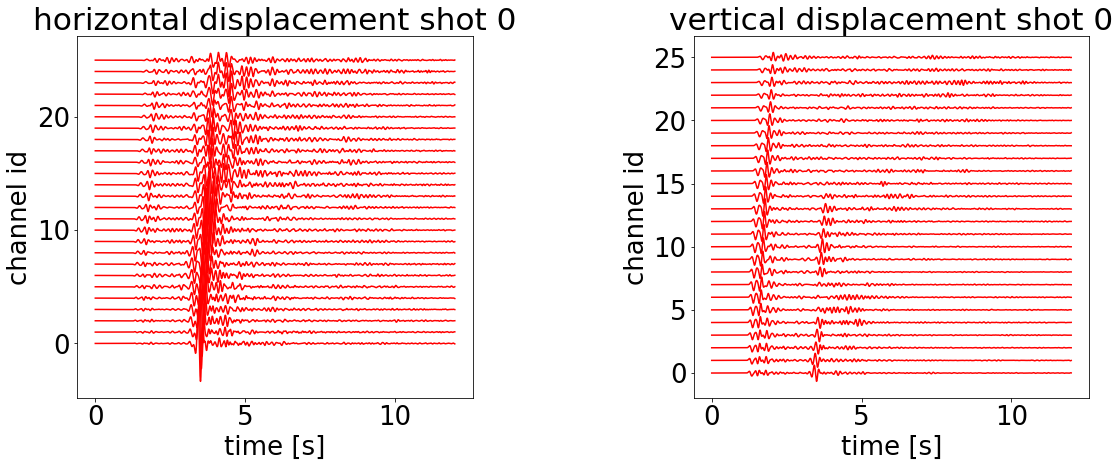

In [11]:
fig,axes = solver.plot_synthetic_data(exagerration=3)
plt.tight_layout()
fig.set_size_inches(18, 16)

To display two wavefields (i.e. horizontal and vertical displacement) together, we'll need a custom colormap with some opacity. That is done in the cell below. We tried to find four colours that are easy to distinguish from each other. One set is used for vertical horizontal, on for vertical. Small values become translucent linearly.

In [12]:
cmap = plt.get_cmap("viridis")

color_values_1 = cmap(numpy.arange(cmap.N))
color_values_2 = cmap(numpy.arange(cmap.N))

# https://www.canva.com/colors/color-wheel/print/0025ff+ff00a5+ffda00+00ff5a/

alpha = (
    numpy.hstack(
        [numpy.linspace(1, 0, int(cmap.N / 2)), numpy.linspace(0, 1, int(cmap.N / 2))]
    )
    ** 0.8
)

color_A1 = numpy.array([0, 37, 255])
color_A2 = numpy.array([255, 218, 0])
color_B1 = numpy.array([255, 165, 0])
color_B2 = numpy.array([0, 255, 90])

color_values_1[128:, :-1] = color_A1 / 255
color_values_1[:128, :-1] = color_A2 / 255
color_values_1[:, -1] = alpha

color_values_2[128:, :-1] = color_B1 / 255
color_values_2[:128, :-1] = color_B2 / 255
color_values_2[:, -1] = alpha


from matplotlib.colors import ListedColormap

my_cmap1 = ListedColormap(color_values_1)
my_cmap2 = ListedColormap(color_values_2)

Let's now visualize particle motion! The particle motions are given by the first two arrays that are returned from `solver.get_snapshots()`. It returns in order all shots and then all timesteps. Since we only have one shot (i.e. one source) we are left with the indices for the particle motion as given below.

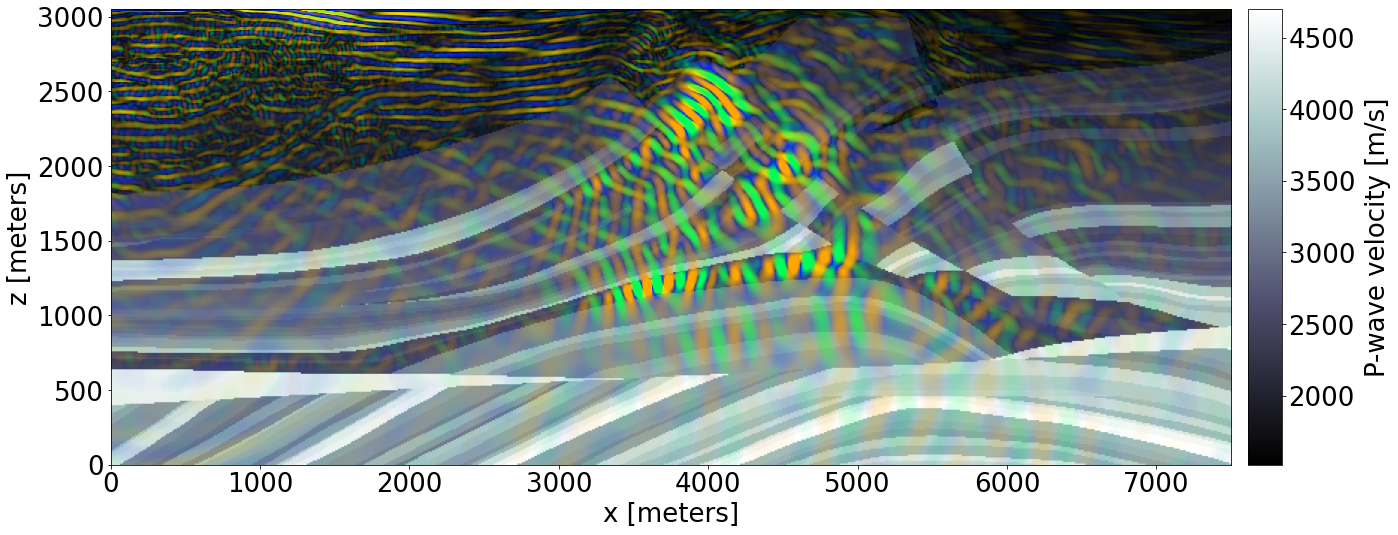

In [13]:
frame_to_plot = 200
all_snapshots = solver.get_snapshots()


fig, ax = plt.subplots(figsize=(18, 8))
plt.tight_layout()


im0 = plt.imshow(
    marmousi.p_veloc.T, cmap=plt.get_cmap("bone"), extent=[0, nx * dx, 0, nz * dz]
)

# First index: dynamic field, second: shot, third: timestep,
# fourth: medium index (cutting off the boundary layer).
wavefield1 = all_snapshots[0][0][frame_to_plot][np:-np, np:-np].T
wavefield2 = all_snapshots[1][0][frame_to_plot][np:-np, np:-np].T

im1 = plt.imshow(
    wavefield1,
    vmin=-300,
    vmax=300,
    cmap=my_cmap1,
    alpha=1.0,
    extent=[0, nx * dx, 0, nz * dz],
)
im2 = plt.imshow(
    wavefield2,
    vmin=-300,
    vmax=300,
    cmap=my_cmap2,
    alpha=1.0,
    extent=[0, nx * dx, 0, nz * dz],
)

plt.xlabel("x [meters]")
plt.ylabel("z [meters]")

ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("right", size="3%", pad="1.5%")
cb1 = fig.colorbar(im0, cax=cax1)

cax1.set_ylabel("P-wave velocity [m/s]", labelpad=10)

plt.show()

Looks wonderful! Have fun.